In [30]:
import torch
import torchvision
from IPython import display
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch import nn

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = '/data',
    train = True,
    transform = trans,
    download = True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root = '/data',
    train = False,
    transform = trans,
    download = True
)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
train_data, train_targets = next(iter(data.DataLoader(mnist_train, batch_size = 18)))

In [5]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers = get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle = True, num_workers = get_dataloader_workers())

In [6]:
num_inputs = 28 ** 2
num_outputs = 10
W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

In [7]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim = True)
    return X_exp / partition

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [9]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [10]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

In [11]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

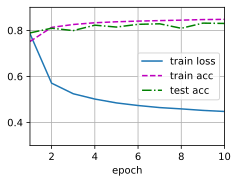

In [12]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

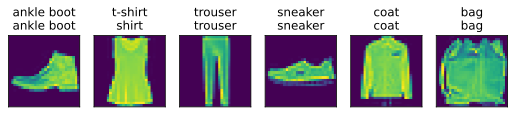

In [13]:
def predict_ch3(net, test_iter, n = 6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0: n].reshape((n, 28, 28)), 1, n, titles = titles[0:n])

predict_ch3(net, test_iter)

In [14]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



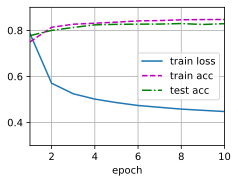

In [34]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)